# Notebook imports

In [1]:
import os
import sys
from os.path import join
import numpy as np 
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup as htmlRemover
from wordcloud import WordCloud
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# Constant

In [2]:
cons=r'SpamData\01_Processing\spam_assassin_corpus\spam_1\00002.d94f1b97e48ed3b553b3508d116e6a09'
spam_1_path=r'SpamData\01_Processing\spam_assassin_corpus\spam_1'
spam_2_path=r'SpamData\01_Processing\spam_assassin_corpus\spam_2'
non_spam_1_path=r'SpamData\01_Processing\spam_assassin_corpus\easy_ham_1'
non_spam_2_path=r'SpamData\01_Processing\spam_assassin_corpus\easy_ham_2'
Data_to_Json=r'SpamData\01_Processing\email_text_data.json'
Data_to_Csv=r'SpamData\01_Processing\email_text_data.csv'
Vocab_to_Csv=r'SpamData\01_Processing\words_by_ids.csv'
is_spam_clas=1
not_spam_clas=0
whale_mask=r'C:\Users\Re\Desktop\CodingProject\ml\SpamData\01_Processing\wordcloud_resources\whale-icon.png'
skul_mask=r'C:\Users\Re\Desktop\CodingProject\ml\SpamData\01_Processing\wordcloud_resources\skull-icon.png'
thumbs_down=r'C:\Users\Re\Desktop\CodingProject\ml\SpamData\01_Processing\wordcloud_resources\thumbs-down.png'
thumbs_up=r'C:\Users\Re\Desktop\CodingProject\ml\SpamData\01_Processing\wordcloud_resources\thumbs-up.png'
vocab_size=2500

In [3]:
with open(cons,encoding='latin-1') as stream:
    is_body=False
    lines=[]
    for line in stream:
        if is_body:
            lines.append(line)
        elif line=='\n':
            is_body=True
email_body='\n'.join(lines)

# extracting email body

In [4]:
def email_body_genrator(path):
    for dirpath, dirname, filesname in os.walk(path):
        for file_name in filesname:
            filepath=join(dirpath,file_name)
            with open(filepath,encoding='latin-1') as stream:
                is_body=False
                lines=[]
                for line in stream:
                    if is_body:
                        lines.append(line)
                    elif line=='\n':
                        is_body=True
            email_body='\n'.join(lines)
            yield file_name, email_body

In [5]:
def df_from_dir(path,classification):
    rows=[]
    rows_name=[]
    for fileName,emailBody in email_body_genrator(path):
        rows.append({'Message':emailBody,'classification':classification})
        rows_name.append(fileName)
    return pd.DataFrame(rows,index=rows_name)

In [6]:
spam_emails=df_from_dir(spam_1_path,is_spam_clas)
spam_emails=spam_emails.append(df_from_dir(spam_2_path,is_spam_clas))
spam_emails.shape

(1897, 2)

In [7]:
non_spam_emails=df_from_dir(non_spam_1_path,not_spam_clas)
non_spam_emails = non_spam_emails.append(df_from_dir(non_spam_2_path,not_spam_clas))

In [8]:
non_spam_emails.head()

,Message,classification
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [9]:
data=pd.concat([spam_emails,non_spam_emails])
print(f'shape of entire data {data.shape}')

shape of entire data (5798, 2)


In [10]:
data.head()

,Message,classification
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
00006.5ab5620d3d7c6c0db76234556a16f6c1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1


# Data cleaning: checking for missing values

In [11]:
data.Message.isnull().values.any()

False

In [12]:
#cehcking if there are empty emails
(data.Message.str.len()==0).sum()

3

### locate empty emails

In [13]:
data[data.Message.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [14]:
data.index.get_loc('cmds')
data=data.drop('cmds')

# Adding IDs to track Emails in DataSet

In [15]:
document_id=range(0,len(data.index))

In [16]:
data['Doc_id']=document_id
data['File_name']=data.index
data.set_index('Doc_id',inplace=True)
data.tail()

,Message,classification,File_name
Doc_id,,,
5790,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5791,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5792,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5793,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5794,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


In [17]:
#Saving data in Json format
data.to_json(Data_to_Json)
data.to_csv(Data_to_Csv)

In [18]:
frequeency=data.classification.value_counts()
print(frequeency)

0    3900
1    1895
Name: classification, dtype: int64


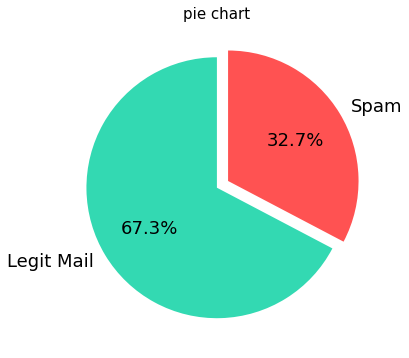

In [19]:
plt.figure(figsize=(6,6))
custom_color=['#33d9b2','#ff5252']
plt.pie(frequeency,labels=["Legit Mail","Spam"],colors=custom_color,
        textprops={'fontsize':18},
        autopct='%1.1f%%',
        startangle=90,explode=[0,0.1])
plt.title("pie chart",size=15)
plt.show()

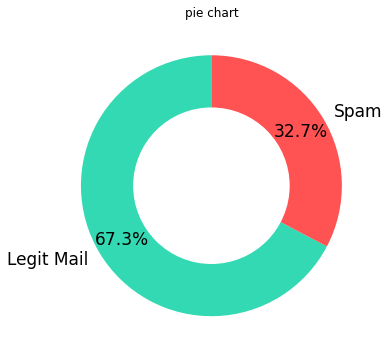

In [20]:
#donut chart
plt.figure(figsize=(6,6))
custom_color=['#33d9b2','#ff5252']
plt.pie(frequeency,labels=["Legit Mail","Spam"],colors=custom_color,
        textprops={'fontsize':17},
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.8)

center_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.title("pie chart")
plt.show()

# Natural language processing
### Text pre-processing
### Downloading the NLTK resources (Tokenizer & Stopwrod)

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Re\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Re\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Re\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Re\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

#### tokenize mean splitting words in a sentence to individual word

In [22]:
msg='lerom ipsum arguing bought lara the frenading going back to the basics???, where i should mention that I dont really care!'
stmmer=SnowballStemmer("english")
words=word_tokenize(msg)
stop_words=set(stopwords.words('english'))
filterd_word=[stmmer.stem(word) for word in words if word not in stop_words and word.isalpha() ]
filterd_word

['lerom',
 'ipsum',
 'argu',
 'bought',
 'lara',
 'frenad',
 'go',
 'back',
 'basic',
 'mention',
 'i',
 'dont',
 'realli',
 'care']

# Removing HTML tags from emails

In [23]:
#cleared_html.get_text()
cleared_html=htmlRemover(data.at[2,'Message'],'html.parser')

In [24]:
def clean_email(message,stemmer=PorterStemmer()):
    words=word_tokenize(htmlRemover(message,'html.parser').get_text())
    stop_words=set(stopwords.words('english'))
    filterd_word=[stmmer.stem(word) for word in words if word not in stop_words and word.isalpha() ]
    return filterd_word

In [25]:
%%time
nested_lists=data.Message.apply(clean_email)

C:\Users\Re\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 43.6 s


In [26]:
#creating a subset is for spam emails and non spam emails (ham)
doc_ids_spam=nested_lists[data.classification==1].index
doc_ids_ham=nested_lists[data.classification==0].index

In [27]:
doc_ids_ham

Int64Index([1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
            ...
            5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794],
           dtype='int64', name='Doc_id', length=3900)

In [28]:
#Subsetting a series with an index
nested_list_ham=nested_lists.loc[doc_ids_ham]
nested_list_spam=nested_lists.loc[doc_ids_spam]

In [29]:
nested_list_spam

Doc_id
0       [fight, the, risk, cancer, http, slim, down, g...
1       [fight, the, risk, cancer, http, slim, down, g...
2       [adult, club, offer, free, membership, instant...
3       [i, thought, might, like, slim, down, guarante...
4       [a, powerhous, gift, program, you, do, want, t...
                              ...                        
1890    [want, to, be, your, own, boss, train, now, wi...
1891    [this, messag, mime, format, prefer, just, doc...
1892    [dear, subscrib, if, i, could, show, way, get,...
1893    [custom, appreci, sale, to, express, appreci, ...
1894    [attn, strict, confidenti, i, pleas, introduc,...
Name: Message, Length: 1895, dtype: object

In [30]:
count_ham=[item for sublist in nested_list_ham for item in sublist]
normal_word=pd.Series(count_ham).value_counts()
normal_word[0:10]

i        12193
http      6609
the       3915
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
dtype: int64

In [31]:
count_spam=[item for sublist in nested_list_spam for item in sublist]
spammy_words_count=pd.Series(count_spam).value_counts()
spammy_words_count[0:10]

i        4066
email    3088
http     2902
the      2872
free     2582
you      2572
this     2351
to       2277
click    2056
we       2005
dtype: int64

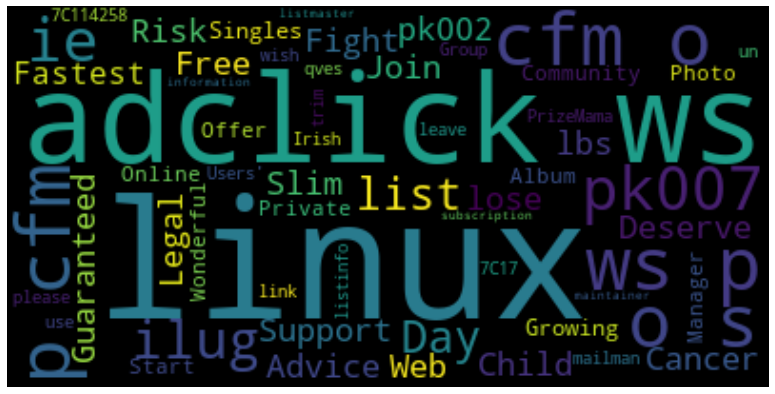

In [32]:
word_cloud=WordCloud().generate(email_body)
plt.figure(figsize=(14,7))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
moby_dick=[''.join(word) for word in nltk.corpus.gutenberg.words('melville-moby_dick.txt') if word.isalpha() and word not in stop_words]
moby_dick=' '.join(moby_dick) 

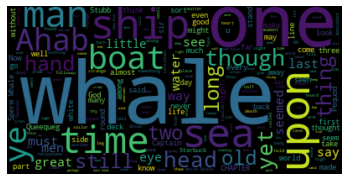

In [34]:
moby_cloud=WordCloud().generate(moby_dick)
plt.imshow(moby_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
icon = Image.open(whale_mask)
image_mask= Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_arry=np.array(image_mask)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Re\\Desktop\\CodingProject\\ml\\SpamData\\01_Processing\\wordcloud_resources\\whale-icon.png'

In [ ]:
%%time
moby_cloud=WordCloud(mask=rgb_arry,background_color='white',max_words=400,colormap='ocean').generate(moby_dick)
plt.figure(figsize=(14,7))
plt.imshow(moby_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
hamlet=[''.join(word) for word in nltk.corpus.shakespeare.words('hamlet.xml') if word.isalpha() and word not in stop_words]
hamlet_play=' '.join(hamlet)


In [ ]:
skul_icon=Image.open(skul_mask)
skul=Image.new(mode='RGB',size=skul_icon.size,color=(255,255,255))
skul.paste(skul_icon,box=skul_icon)
rgb_skull=np.array(skul)

In [ ]:
hamlet_word_cloud=WordCloud(mask=rgb_skull, background_color='white',max_words=1600,colormap='bone').generate(hamlet_play)
plt.figure(figsize=(16,10))
plt.imshow(hamlet_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
thumbs_down_icon=Image.open(thumbs_down)
thumb_down=Image.new(mode='RGB',size=thumbs_down_icon.size,color=(255,255,255))
thumb_down.paste(thumbs_down_icon,box=thumbs_down_icon)
arry_thumbs_down=np.array(thumb_down)

In [ ]:
str_spam=' '.join(count_spam)
spam_word_cloud=WordCloud(mask=arry_thumbs_down,background_color='white',max_words=1200,colormap='YlOrRd').generate(str_spam)
plt.figure(figsize=(16,10))
plt.imshow(spam_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
thumbs_up_icon=Image.open(thumbs_up)
thumb_up=Image.new(mode='RGB',size=thumbs_up_icon.size,color=(255,255,255))
thumb_up.paste(thumbs_up_icon,box=thumbs_up_icon)
arry_thumbs_up=np.array(thumb_up)

In [ ]:
str_ham=' '.join(count_ham)
ham_word_cloud=WordCloud(mask=arry_thumbs_up,max_words=1200,background_color='white',colormap='YlGnBu').generate(str_spam)
plt.figure(figsize=(16,10))
plt.imshow(ham_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate vocabulary and dictionary

In [ ]:
frequente_word=pd.DataFrame(count_spam).value_counts()[0:vocab_size]
print(frequente_word)

# Create Vocabulary DataFrame with a Word_ID

In [ ]:
word_ids=list(range(0,vocab_size))
vocab=pd.DataFrame({'Vocab_word':frequente_word.index.values},index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

In [ ]:
stammed_flat_list=data.Message.apply(clean_email)
flat_stammed_list=[item for sublist in stammed_flat_list  for item in sublist]

In [ ]:
unique_word=pd.Series(flat_stammed_list).value_counts()
print('Nr of unique words',unique_word.shape[0])
unique_word.head()

In [ ]:
#saving the vocabulary into a csv file formate
vocab.to_csv(Vocab_to_Csv)